In [1]:
from lib.preamble import *

%matplotlib inline

data = []

# Import data

In [3]:
paths = glob("../data/2024-01-16*/d*")
paths.sort()

In [4]:
# import backgrounds
import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

import difflib

def background_substract_substract(sel, b):
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d

bkg = [custom_import_spectra(p) for p in paths if p.endswith(".asc") and "bkg" in p]

# create a script that
def background_substract(sel): 
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_substract(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)
 
pprint([b.name for b in bkg])

['2024-01-16 NiPS3_bulk inPlane/d002_bkg_5x5s',
 '2024-01-16 NiPS3_bulk inPlane/d004_bkg_3x20s',
 '2024-01-16 NiPS3_bulk inPlane/d007_bkg_3x0',
 '2024-01-16 NiPS3_bulk inPlane/d009_bkg_3x10s',
 '2024-01-16 NiPS3_bulk inPlane/d012_bkg_5x45s']


In [5]:

# import all from 2023-12-06 and 07 done with custom script
import h5py

def import_custom_script(p):
	with h5py.File(p, "r") as f:
		angle_count = len(np.unique(f['apt_angle']))

		if "magnet_field" in f:
			field = f["magnet_field"][::angle_count]
		else:
			field = np.array([np.nan])

		angle = f["apt_angle"][:angle_count]
		wavelength = f["wavelength"][0]
		counts = f["counts"][:].reshape(field.shape[0], angle.shape[0], wavelength.shape[0])

		time = f["time"][:].reshape(field.shape[0], angle.shape[0])

		if "temperature" in f:
			temperature = f["temperature"][:].reshape(field.shape[0], angle.shape[0])
		else:
			temperature = np.full_like(time, np.nan)

		if "position" in f:
			position = f["position"][:].reshape(field.shape[0], angle.shape[0], 3)
		else:
			position = np.full_like(counts, np.nan)

		exposure = f["data_full"]["spectrometer"]["exposure"][0]
		number = f["data_full"]["spectrometer"]["number"][0]

	ar = xr.DataArray(
		counts,
		dims=["field", "angle", "wavelength"],
		coords={
			"field": field,
			"angle": angle,
			"wavelength": wavelength,
		},
		attrs={
			"exposure": exposure,
			"number": number,
		}
	)

	# add coord time
	ar.coords["time"] = (
		["field", "angle"],
		time
	)

	# add coord temperature
	ar.coords["temperature"] = (
		["field", "angle"],
		temperature
	)

	return ar

def import_files(p):

	try:
		ar = import_custom_script(p)
	except:
		print(f"Error importing:\t{p}")
		return None

	# if ar is None:
		# return None
	
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data = [import_files(p) for p in paths if p.endswith(".h5") and "raman" in p]
data = [d for d in data if d is not None]
data = [background_substract(d) for d in data]

pprint({i: d.name for i, d in enumerate(data)})

Error importing:	../data/2024-01-16 NiPS3_bulk inPlane/d008_raman_circExc_linDet_10K_10mW.hd5.h5
{0: '2024-01-16 NiPS3_bulk inPlane/d010_raman_circExc_linDet_10K_10mW.hd5'}


# Preliminarie analysis

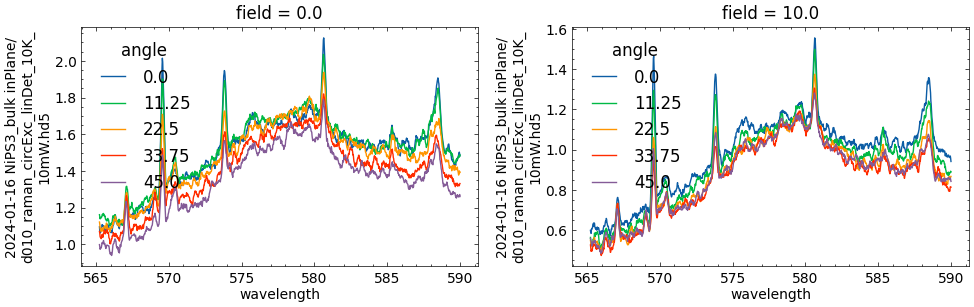

In [6]:
def plot(d, ax):
    d.sel(wavelength=slice(565, 590)).rolling(wavelength=10).mean().plot.line(hue="angle", ax=ax)

sel = data[0]

fig, axs = plt.subplots(1, 2, figsize=FIGSIZE_WIDE)
plot(sel.isel(field=0), axs[0])
plot(sel.sel(field=10), axs[1])

In [14]:
pol = polarisation_binned(data[0].sel(wavelength=slice(565, 590)), wavelength=30)

In [33]:
sel = data[0].sel(wavelength=slice(565, 590)).coarsen(wavelength=10, boundary="trim").mean()
pol = polarisation_xarray(sel)

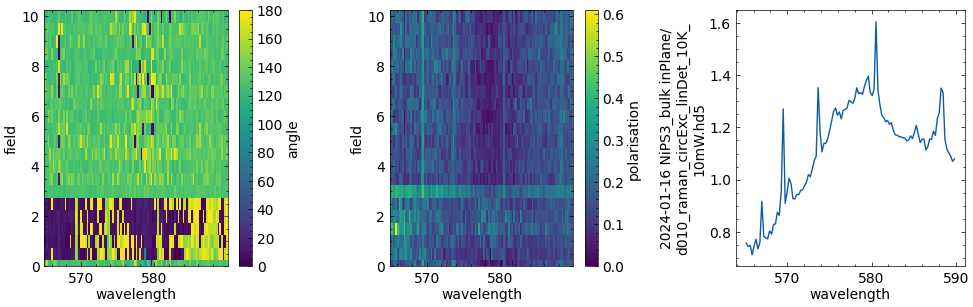

In [35]:
plt.figure(figsize=FIGSIZE_WIDE)
plt.subplot(131)
pol.angle.sortby("field").plot(vmin=0, vmax=180)
plt.subplot(132)
pol.polarisation.sortby("field").plot()
plt.subplot(133)
sel.sortby("field").mean(["angle", "field"]).plot()
plt.show()

In [64]:
sel.field[:-1].data

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

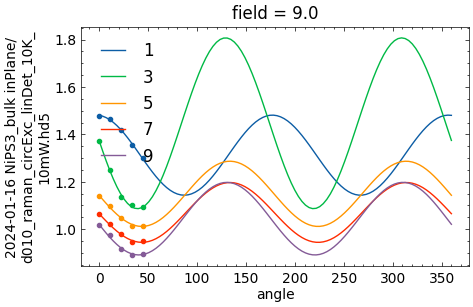

In [69]:
plt.figure()
for field in [1, 3,  5,  7,  9]:
	i = sel.sel(field=field).mean("wavelength")
	popt,pcov = fit_cos_sqr(i.angle, i)
	angles = np.linspace(0, 360, 100)
	line = plt.plot(angles, cos_sqr(angles, *popt), label=field)
	i.plot.line(color=line[0].get_color(), linestyle="none", marker="o")
plt.legend()